## Prediction of sugarcane productivity in São Paulo State

#### Part 1: Exploratory analysis and cleaning of sugarcane productivity data obtained from the IBGE website

In this first part we will analyze the productivity data for each municipality. The steps consist of separating the original csv in each of the tables and searching for missing values

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas as gp
import earthpy.plot as ep
import missingno
import folium
import rioxarray
import xarray
import sys
import warnings
import rasterio
import seaborn as sns
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from shapely import geometry

In [ ]:
# Load data and create 'chunks' for each table. Save separately to computer
for i, chunk in enumerate(pd.read_csv('tabela1612.csv',  encoding ='ISO-8859-1', decimal = ',', sep = ';', chunksize=648)):
    chunk.to_csv('chunk{}.csv'.format(i), index=False, encoding ='ISO-8859-1', decimal = '.')

At the end of the original table we have the following descriptions:

  - Absolute zero, not resulting from a calculation or rounding (-)
  - Zero resulting from a calculation or rounding (0)
  - Value does not apply. Ex: It is not possible to obtain the total agricultural production in a given municipality when agricultural products are accounted for with different measurement units (..)
  - Value not available. Ex: The production of beans in a certain municipality was not researched or a certain municipality did not exist in the year of the research (...)
  
After checking the productivity data with the planted area data, it was possible to observe that the municipalities that do not have numerical values and present any of the symbols mentioned above, do not have a value for some of the reasons mentioned above, but mainly because there was no record of planted area. Then, we will use two strategies, the first one will be to replace all the symbols with NaN that will later be filled with the average, to complete all the spaces. The second strategy will be to use the data with the NaNs.

The first step then is to replace the symbols with 'NaN'


In [2]:
# Load the table that contains the sugarcane productivity for each year. Delete the first 4 lines and the last 2.
# Create a list of symbols representing the missing values and use this list to replace NAs.
lista_ausentes = ['-', '..', '...']
dat = pd.read_csv("tables/chunk5.csv", skiprows = 3, na_values = lista_ausentes).drop([0, 643, 644])
dat.reset_index(drop = True, inplace = True)
dat.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000,80000,76311,77794,80000,81307,75000,100000,...,75000,60000,70000,60000,80000,80000,80000,70000,75000,70000
1,3500204,Adolfo (SP),NaN,80000,NaN,NaN,120000,89009,100000,100000,...,90000,90000,90000,70000,70000,80000,90000,90000,90000,90000
2,3500303,Aguaí (SP),80000,NaN,87000,86089,86000,85434,85000,85000,...,90000,90000,100000,100000,80000,90000,90000,85000,85000,85000
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000,90000,90000,90000,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Size of the dataset
dat.shape

(642, 23)

In [4]:
# Info
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Cód.       642 non-null    object
 1   Município  642 non-null    object
 2   2000       381 non-null    object
 3   2001       383 non-null    object
 4   2002       418 non-null    object
 5   2003       421 non-null    object
 6   2004       438 non-null    object
 7   2005       450 non-null    object
 8   2006       467 non-null    object
 9   2007       483 non-null    object
 10  2008       506 non-null    object
 11  2009       500 non-null    object
 12  2010       521 non-null    object
 13  2011       530 non-null    object
 14  2012       491 non-null    object
 15  2013       516 non-null    object
 16  2014       511 non-null    object
 17  2015       508 non-null    object
 18  2016       512 non-null    object
 19  2017       514 non-null    object
 20  2018       519 non-null    objec

All columns were read as 'object'. So we need to convert to numeric

In [5]:
# Select columns to convert
cols = dat.columns.drop(["Município"]).tolist()
cols

['Cód.',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020']

In [6]:
# Convert columns to numeric type
dat[cols] = dat[cols].apply(pd.to_numeric)
dat.head()

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.0,90000.0,90000.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Size
dat.shape

(642, 23)

In [8]:
# Info
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Cód.       642 non-null    int64  
 1   Município  642 non-null    object 
 2   2000       381 non-null    float64
 3   2001       383 non-null    float64
 4   2002       418 non-null    float64
 5   2003       421 non-null    float64
 6   2004       438 non-null    float64
 7   2005       450 non-null    float64
 8   2006       467 non-null    float64
 9   2007       483 non-null    float64
 10  2008       506 non-null    float64
 11  2009       500 non-null    float64
 12  2010       521 non-null    float64
 13  2011       530 non-null    float64
 14  2012       491 non-null    float64
 15  2013       516 non-null    float64
 16  2014       511 non-null    float64
 17  2015       508 non-null    float64
 18  2016       512 non-null    float64
 19  2017       514 non-null    float64
 20  2018      

In [9]:
# Describe the data
dat.describe()

,Cód.,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,6.420000e+02,381.000000,383.000000,418.000000,421.000000,438.000000,450.000000,467.000000,483.000000,506.000000,...,530.000000,491.000000,516.000000,511.000000,508.000000,512.000000,514.000000,519.000000,518.000000,515.000000
mean,3.528703e+06,75104.435696,75308.028721,76572.440191,77986.137767,78883.949772,79697.422222,82600.933619,82760.086957,81830.237154,...,80818.015094,77962.959267,79305.798450,72675.874755,76010.992126,78120.646484,78526.655642,76118.510597,75444.432432,76552.504854
std,1.670696e+04,14495.151189,13403.233625,13235.901627,16007.396004,12854.484601,14299.738869,18373.835703,16359.525897,15927.510433,...,14442.579189,10483.770858,11879.309913,11713.637097,12066.415642,12746.845468,12467.961083,14014.284852,12272.952003,12128.665299
min,3.500105e+06,10000.000000,10000.000000,30000.000000,21676.000000,30000.000000,11955.000000,14000.000000,13000.000000,9000.000000,...,100.000000,20819.000000,1200.000000,20000.000000,20000.000000,10000.000000,10000.000000,2000.000000,2000.000000,2000.000000
25%,3.514626e+06,70000.000000,70000.000000,70000.000000,70000.000000,71564.250000,74497.000000,75000.000000,75000.000000,75000.000000,...,74000.000000,70157.500000,73000.000000,65430.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
50%,3.528754e+06,75000.000000,77931.000000,80000.000000,80000.000000,80000.000000,79475.000000,80000.000000,80000.000000,81202.500000,...,80000.000000,80000.000000,80000.000000,71604.000000,75000.000000,80000.000000,80000.000000,79223.000000,75000.000000,78000.000000
75%,3.543179e+06,80000.000000,80000.000000,83913.500000,85000.000000,85856.250000,89396.000000,90000.000000,90000.000000,90000.000000,...,90000.000000,85000.000000,85000.000000,80000.000000,80000.000000,85000.000000,85000.000000,85000.000000,80000.000000,82000.000000
max,3.557303e+06,150000.000000,130000.000000,124900.000000,170764.000000,120000.000000,119423.000000,250000.000000,150000.000000,130000.000000,...,125000.000000,112073.000000,120049.000000,120000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000


Na tabela acima podemos observar que não temos dados para todos os Municípios em todos os anos. Se completo, deveria ser 642 na linha 'count'. Portanto, vemos que há muitos dados faltantes. Nos próximos códigos vamos analisar esses dados faltantes e como proceder da melhor forma.

In [13]:
# Function to calculate the total of missing values
def calc_ausentes(df):

    # Total values in the dataset
    total_values = np.product(df.shape)

    # Number of missing values per column
    colvalues_missing = df.isnull().sum()

    # Total missing values and percentage
    missing_total = colvalues_missing.sum()
    missing_percent = round(((missing_total/total_values) * 100), 2)

    # Print result
    print('Dataset has {}% missing values'.format(missing_percent))
    
    
# Function to calculate missing values by column
def cal_ausentes_coluna(df):
    
    # Number of missing values per column
    col_missing = df.isnull().sum()

    # Number of missing values per column
    col_missing_percent = 100 * col_missing / len(df)

    # Data type of columns with missing values
    col_missing_dtype = df.dtypes

    # Create a table with the results
    col_missing_table = pd.concat([col_missing, col_missing_percent, col_missing_dtype], axis=1)

    # Rename the columns
    col_missing_table = col_missing_table.rename(
    columns = {0 : 'Missing values', 1 : '% of Missing values', 2: 'Dtype'})

    # Sort the table by percentage of missing values descending and remove columns with no missing values
    col_missing_table = col_missing_table[\
                                          col_missing_table.iloc[:,0] != 0].sort_values('% of Missing values', \
                                                                                        ascending = False).round(2)

    # Print 
    print ("The dataset has " + str(df.shape[1]) + " columns.\n"
        "Found: " + str(col_missing_table.shape[0]) + " columns with missing values.")

    if col_missing_table.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return col_missing_table

# Function that calculates the percentage of rows with missing values
def calc_ausentes_linha(df):

    # Calculates the total number of rows with missing values
    missing_rows = sum([True for idx, row in df.iterrows() if any(row.isna())])

    # Calculate the total number of lines
    total_rows = df.shape[0]

    # Calculates the percentage of missing lines
    percen_ausentes = round(((missing_rows/total_rows) * 100), 2)
    
    print('Dataset has {} % of rows with at least one missing value.'.format(percen_ausentes))

In [11]:
# Check the percentage of missing values
calc_ausentes(dat)

Dataset has 22.89% missing values


In [14]:
# Check missing values in columns
cal_ausentes_coluna(dat)      

The dataset has 23 columns.
Found: 21 columns with missing values.


,Missing values,% of Missing values,Dtype
2000,261,40.65,float64
2001,259,40.34,float64
2002,224,34.89,float64
2003,221,34.42,float64
2004,204,31.78,float64
2005,192,29.91,float64
2006,175,27.26,float64
2007,159,24.77,float64
2012,151,23.52,float64
2009,142,22.12,float64


In [15]:
# Check for missing values in lines
calc_ausentes_linha(dat)

Dataset has 51.09 % of rows with at least one missing value.


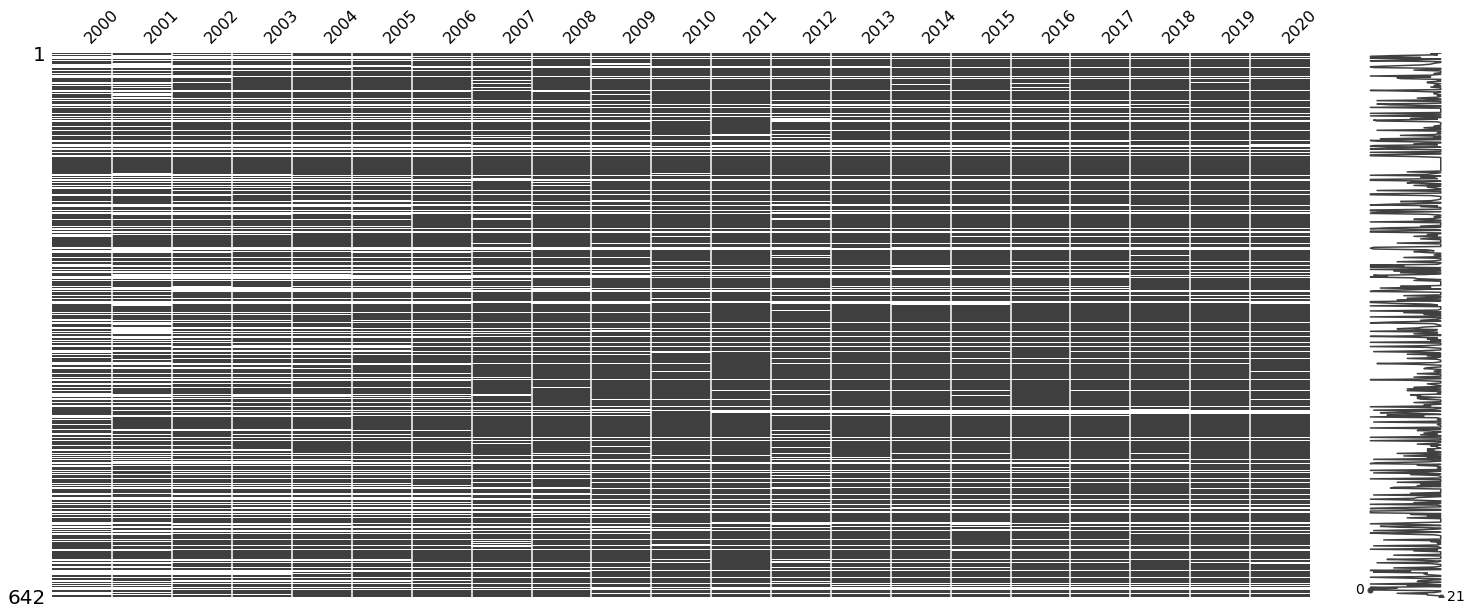

In [16]:
# Plot map of missing values
dat_nan = pd.DataFrame(dat.isna().sum())

if dat.isna().any(axis = None):
    missingno.matrix(dat[dat_nan[dat_nan[0]>0].index])
    plt.show()

We have a pattern of variation in the data. There are entire lines with empty cells, which means that several municipalities did not produce sugarcane in any of the years studied. Then, the next step is to identify the percentage of these missing values in each row and column. At first we will focus on deleting the missing values in the rows for all years.

What you need to do now is count the null values for each municipality, to make sure if it's just a few values missing or the percentage is higher. If the missing values in each municipality represent more than 40%, the municipality will be excluded from the analysis

In [17]:
# Count rows with missing values
missing_rows = sum([True for idx,row in dat.iterrows() if any(row.isna())])
print("We have {} rows with missing values".format(missing_rows))

We have 328 rows with missing values


In [18]:
## Create a dataframe with the percentage of missing values calculation for each row
rows_missing = dat.isnull().sum(axis=1)
rows_perc = round(((rows_missing / 21) * 100), 2)
mis_val_table = pd.concat([dat['Município'], rows_missing, rows_perc], axis = 1)
mis_val_table.rename(columns = {0: 'Missing total', 1: '% Missing'}, inplace = True)
mis_val_table.head()

,Município,Missing total,% Missing
0,Adamantina (SP),0,0.00
1,Adolfo (SP),3,14.29
2,Aguaí (SP),1,4.76
3,Águas da Prata (SP),15,71.43
4,Águas de Lindóia (SP),21,100.00


In [19]:
# Contar as linhas com 100% e > 50% de valores ausentes
rows_to_remove = mis_val_table[mis_val_table['% Missing'] == 100].index.tolist()
rows_40perc = mis_val_table[mis_val_table['% Missing'] >= 40.00].index.tolist()
print('There are {} lines with no record of sugarcane production for all years'.format(len(rows_to_remove)))
print('There are {} rows with more than 40% missing values'.format(len(rows_40perc)))

There are 68 lines with no record of sugarcane production for all years
There are 156 rows with more than 40% missing values


In [20]:
dat.iloc[rows_40perc]

,Cód.,Município,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3,3500402,Águas da Prata (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60000.0,90000.0,90000.0,90000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3500501,Águas de Lindóia (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3500600,Águas de São Pedro (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3500808,Alfredo Marcondes (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,3501301,Álvares Machado (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75000.0,75000.0,75000.0,80000.0,100000.0,100000.0,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,3556453,Vargem Grande Paulista (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
631,3556503,Várzea Paulista (SP),NaN,NaN,50000.0,50000.0,50000.0,52000.0,50000.0,50000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632,3556602,Vera Cruz (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
633,3556701,Vinhedo (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After checking the missing values, we conclude that 156 rows will be removed.

In [21]:
# Remove the data with more than 40% of NaN values
dat_clean = dat.drop(rows_40perc)
dat_clean.shape

(486, 23)

Let's re-plot the graph to check the pattern of missing values

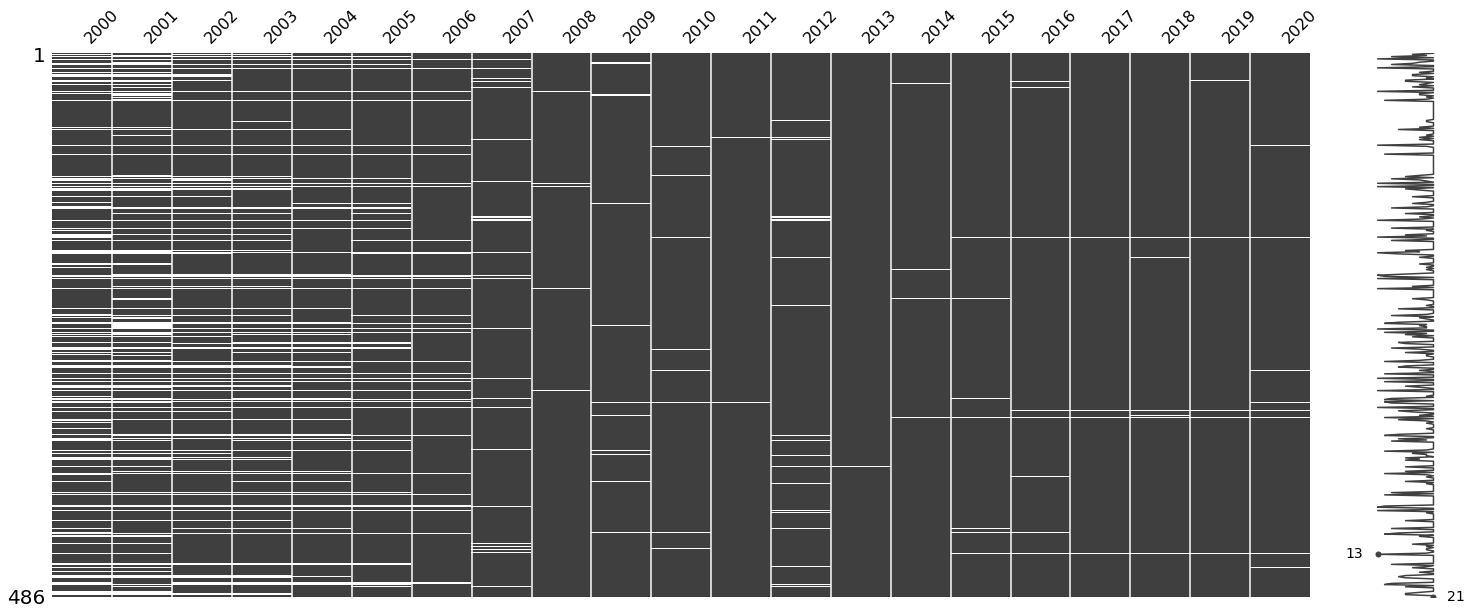

In [22]:
# Plot - Map of Missing Values
dat_nan = pd.DataFrame(dat_clean.isna().sum())

if dat_clean.isna().any(axis = None):
    missingno.matrix(dat_clean[dat_nan[dat_nan[0]>0].index])
    plt.show()

In [57]:
# Count rows with missing values
missing_rows = sum([True for idx,row in dat_clean.iterrows() if any(row.isna())])
print("Temos {} linhas com valores ausentes". format(missing_rows))

Temos 172 linhas com valores ausentes


So far we have been identifying missing values and excluding those who are not useful for our analysis. We still have 172 counties with missing values. However, for now, we will left it and later we'll come back to it. In the next scripts we will be working in making some graphs to understand the distribution of our dataset.

In [30]:
# Rename columns
dat_clean.rename(columns = {'Cód.': 'CD_MUN', 'Município': 'County'}, inplace = True)
dat_clean.head()

,CD_MUN,County,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
5,3500550,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,NaN,NaN,80333.0,80000.0,...,80000.0,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0
7,3500709,Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,...,79500.0,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0


In [31]:
# Size
dat_clean.shape

(486, 23)

To properly plot the graphs, the data will be reshaped, using the melt function. This will create a new dataframe with all the years in a single column.

In [32]:
# Name is id_vars and Course is value_vars
dat_clean_melt = pd.melt(dat_clean, id_vars =['CD_MUN', 'County'])
dat_clean_melt.head()

,CD_MUN,County,variable,value
0,3500105,Adamantina (SP),2000,50000.0
1,3500204,Adolfo (SP),2000,NaN
2,3500303,Aguaí (SP),2000,80000.0
3,3500550,Águas de Santa Bárbara (SP),2000,NaN
4,3500709,Agudos (SP),2000,70000.0


In [33]:
# Size
dat_clean_melt.shape

(10206, 4)

In [34]:
# Creating heatmap
heatmap_data = pd.pivot_table(dat_clean_melt,values='value', index=['County'], columns='variable')
heatmap_data.head()

variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
County,,,,,,,,,,,,,,,,,,,,,
Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,90000.0,80000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,80000.0,90000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,89080.0,90000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,80000.0,80000.0,...,79500.0,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0
Alambari (SP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75000.0,88888.0,...,92300.0,70000.0,80000.0,72800.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0


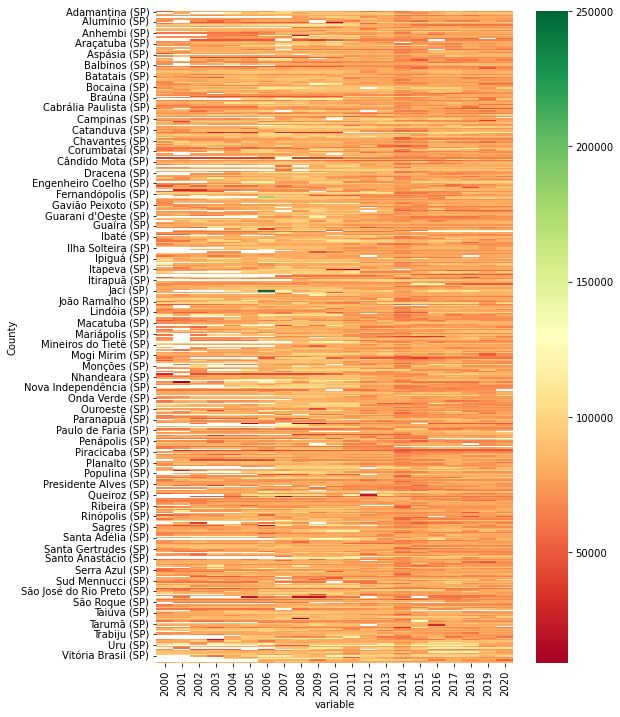

In [35]:
# Plot heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_data, cmap='RdYlGn')
plt.show()

Here we can see another problem. It has productivity above 200,000 kg/ha, a situation that is not very common and that can interfere with our analysis. Therefore, we will identify these municipalities and exclude them from the database.

In [36]:
# Search counties with > 200000
dat_clean.loc[dat_clean['2006'] >= 200000]

,CD_MUN,County,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
276,3524501,Jaci (SP),80000.0,NaN,NaN,NaN,110000.0,89396.0,250000.0,140000.0,...,90000.0,90000.0,100000.0,75000.0,90000.0,110000.0,100000.0,110000.0,90000.0,90000.0


In [37]:
# Drop the county with yield > 200000
dat_clean.drop(276, inplace = True)

In [38]:
# Search again counties with > 200000
dat_clean.loc[dat_clean['2006'] >= 200000]

,CD_MUN,County,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020


In [39]:
# Reset index
dat_clean.reset_index(drop = True, inplace = True)
dat_clean.head()

,CD_MUN,County,2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,75000.0,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0
3,3500550,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,NaN,NaN,80333.0,80000.0,...,80000.0,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0
4,3500709,Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,...,79500.0,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0


In [40]:
# Calculating the average yield over 21 years for each county
dat_clean['mean'] = round(dat_clean.drop(['CD_MUN'], axis = 1).mean(axis=1),2)
dat_clean.head()

,CD_MUN,County,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,mean
0,3500105,Adamantina (SP),50000.0,80000.0,76311.0,77794.0,80000.0,81307.0,75000.0,100000.0,...,60000.0,70000.0,60000.0,80000.0,80000.0,80000.0,70000.0,75000.0,70000.0,75733.90
1,3500204,Adolfo (SP),NaN,80000.0,NaN,NaN,120000.0,89009.0,100000.0,100000.0,...,90000.0,90000.0,70000.0,70000.0,80000.0,90000.0,90000.0,90000.0,90000.0,88833.83
2,3500303,Aguaí (SP),80000.0,NaN,87000.0,86089.0,86000.0,85434.0,85000.0,85000.0,...,90000.0,100000.0,100000.0,80000.0,90000.0,90000.0,85000.0,85000.0,85000.0,88180.15
3,3500550,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,NaN,NaN,80333.0,80000.0,...,100000.0,100000.0,100000.0,90000.0,63000.0,80000.0,70000.0,75000.0,55000.0,80132.27
4,3500709,Agudos (SP),70000.0,70000.0,70000.0,70000.0,77996.0,77723.0,80000.0,88669.0,...,79500.0,79500.0,60004.0,64794.0,61000.0,70000.0,61000.0,70000.0,70000.0,73318.38


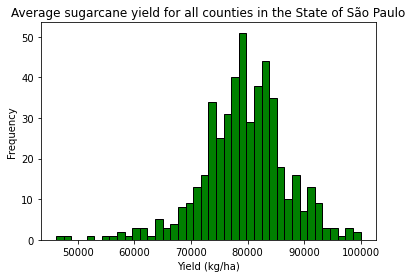

In [48]:
# Histogram of average productivity for each county
plt.hist(dat_clean['mean'], bins = 40, facecolor='green', edgecolor = 'black')
plt.title('Average sugarcane yield for all counties in the State of São Paulo')
plt.xlabel('Yield (kg/ha)')
plt.ylabel('Frequency')
plt.show()

In [42]:
# Calculating quantiles
dat_clean['mean'] = round(dat_clean.drop(['CD_MUN'], axis = 1).mean(axis=1),2)
dat_clean['quantiles'] = pd.qcut(x=dat_clean['mean'], q=5, labels=False)
dat_clean.sort_values('quantiles')

,CD_MUN,County,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,mean,quantiles
161,3518909,Guzolândia (SP),64006.0,65000.0,53148.0,104109.0,98274.0,90067.0,100000.0,70026.0,...,60000.0,70000.0,66360.0,72000.0,72000.0,72000.0,65000.0,70000.0,73582.14,0
349,3540853,Pracinha (SP),60000.0,80000.0,89642.0,86514.0,75000.0,74529.0,70000.0,70000.0,...,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,71699.29,0
81,3509403,Cajuru (SP),70000.0,70000.0,70000.0,70000.0,70000.0,69535.0,80000.0,69247.0,...,60000.0,74100.0,70000.0,70000.0,67200.0,67154.0,67200.0,67200.0,68173.14,0
164,3519071,Hortolândia (SP),NaN,60000.0,60000.0,60000.0,60000.0,59598.0,60000.0,60000.0,...,60000.0,83333.0,NaN,NaN,NaN,NaN,NaN,NaN,61763.92,0
79,3509106,Caiuá (SP),70000.0,70000.0,70000.0,70000.0,70000.0,79463.0,61000.0,61000.0,...,65000.0,64000.0,64000.0,85329.0,64000.0,64000.0,64000.0,64000.0,67990.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,3540002,Pompéia (SP),NaN,NaN,NaN,NaN,NaN,69564.0,80000.0,100000.0,...,100000.0,80000.0,80000.0,90000.0,80000.0,80000.0,80000.0,80000.0,86847.75,4
340,3540101,Pongaí (SP),80000.0,NaN,NaN,NaN,NaN,NaN,NaN,100000.0,...,100000.0,100000.0,80000.0,100000.0,100000.0,80000.0,70000.0,86947.0,92639.07,4
342,3540259,Pontalinda (SP),90000.0,30000.0,60000.0,91538.0,90000.0,79462.0,80000.0,72500.0,...,88016.0,80000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,86519.81,4
348,3540804,Potirendaba (SP),100000.0,100000.0,75000.0,75000.0,80000.0,110445.0,100000.0,100000.0,...,85000.0,79000.0,80000.0,80000.0,100000.0,90000.0,83333.0,80000.0,88703.71,4


In [44]:
# Grouping quantiles
dat_clean_grouped = dat_clean.groupby('quantiles').mean().round(0).astype(int)
dat_clean_grouped.drop(['mean'], axis = 1, inplace = True)
dat_clean_grouped.drop(['CD_MUN'], axis = 1, inplace = True)
dat_clean_grouped

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
quantiles,,,,,,,,,,,,,,,,,,,,,
0,65799,66738,64080,65146,66405,66168,68600,68854,69642,69903,...,70790,70600,72141,67590,70493,70658,70722,69994,70908,70851
1,73683,73119,75198,77278,77669,78719,81389,80038,79073,78352,...,78617,75176,77529,70124,73000,75394,74861,73614,73841,74815
2,74812,78316,79181,78861,80452,80884,81175,84783,84190,85158,...,82838,79020,79438,71563,75295,78237,78922,77540,76291,77569
3,80359,79011,81160,83336,85100,86835,87060,87819,88254,88813,...,84110,80853,83018,75470,79202,82645,82560,80277,79043,79978
4,86921,85098,88606,91267,88716,91107,98620,94965,93757,97257,...,93123,84567,87934,79144,83597,86716,87598,86182,82912,85295


In [45]:
# Rearrange the data - Transpose
dat_clean_grouped_trans = dat_clean_grouped.T
dat_clean_grouped_trans.reset_index(inplace = True)
dat_clean_grouped_trans.rename(columns = {'index': 'YEAR', 0: 'q1', 1: 'q2', 2:'q3', 3:'q4', 4:'q5'}, inplace = True)
dat_clean_grouped_trans['YEAR'] = pd.to_datetime(dat_clean_grouped_trans['YEAR'])
dat_clean_grouped_trans

quantiles,YEAR,q1,q2,q3,q4,q5
0,2000-01-01,65799,73683,74812,80359,86921
1,2001-01-01,66738,73119,78316,79011,85098
2,2002-01-01,64080,75198,79181,81160,88606
3,2003-01-01,65146,77278,78861,83336,91267
4,2004-01-01,66405,77669,80452,85100,88716
5,2005-01-01,66168,78719,80884,86835,91107
6,2006-01-01,68600,81389,81175,87060,98620
7,2007-01-01,68854,80038,84783,87819,94965
8,2008-01-01,69642,79073,84190,88254,93757
9,2009-01-01,69903,78352,85158,88813,97257


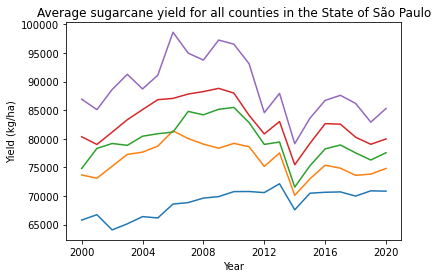

In [47]:
# Plotting grouped quantiles
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q1'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q2'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q3'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q4'])
plt.plot(dat_clean_grouped_trans['YEAR'], dat_clean_grouped_trans['q5'])
plt.title('Average sugarcane yield for all counties in the State of São Paulo')
plt.xlabel('Year')
plt.ylabel('Yield (kg/ha)')
plt.savefig('plot_avergae_yield.png', dpi=80)

plt.show()

#### Gráfico da média anual da produtividade para todos os municípios por ano

In [53]:
# Reshape the dataset, but first delete the 'mean' and 'quantiles' column
dat_clean.drop(['mean', 'quantiles'], axis = 1, inplace = True)
dat_clean_yield = pd.melt(dat_clean, id_vars =['CD_MUN', 'County'])
dat_clean_yield['YEAR'] = dat_clean_yield['variable']
dat_clean_yield.drop(['variable'], axis = 1, inplace = True)
dat_clean_yield

,CD_MUN,County,value,YEAR
0,3500105,Adamantina (SP),50000.0,2000
1,3500204,Adolfo (SP),NaN,2000
2,3500303,Aguaí (SP),80000.0,2000
3,3500550,Águas de Santa Bárbara (SP),NaN,2000
4,3500709,Agudos (SP),70000.0,2000
...,...,...,...,...
10180,3556958,Vitória Brasil (SP),100000.0,2020
10181,3557105,Votuporanga (SP),70000.0,2020
10182,3557154,Zacarias (SP),80000.0,2020
10183,3557204,Chavantes (SP),78960.0,2020


In [54]:
# Calculate the mean and standard deviation for each year
mean_yield = pd.DataFrame(dat_clean_yield.groupby('YEAR')['value'].mean().reset_index())
std_yield = pd.DataFrame(dat_clean_yield.groupby('YEAR')['value'].std().reset_index())
mean_st_merged = mean_yield.merge(std_yield, left_index=True, right_index=True)
mean_st_merged.rename(columns = {"value_x": 'mean_yield', "value_y": "st_yield"}, inplace = True)
mean_st_merged['YEAR_x'] = pd.to_datetime(mean_st_merged['YEAR_x'], format = '%Y')
mean_st_merged.drop('YEAR_y', axis = 1, inplace = True)
mean_st_merged.rename(columns = {'YEAR_x': 'YEAR'}, inplace = True)
mean_st_merged['mean_yield'] = mean_st_merged['mean_yield'].astype(int)
mean_st_merged['st_yield'] = mean_st_merged['st_yield'].astype(int)
mean_st_merged

,YEAR,mean_yield,st_yield
0,2000-01-01,75969,13500
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79643,11929
5,2005-01-01,80676,13389
6,2006-01-01,83121,15964
7,2007-01-01,83527,15152
8,2008-01-01,82932,14603
9,2009-01-01,84085,15322


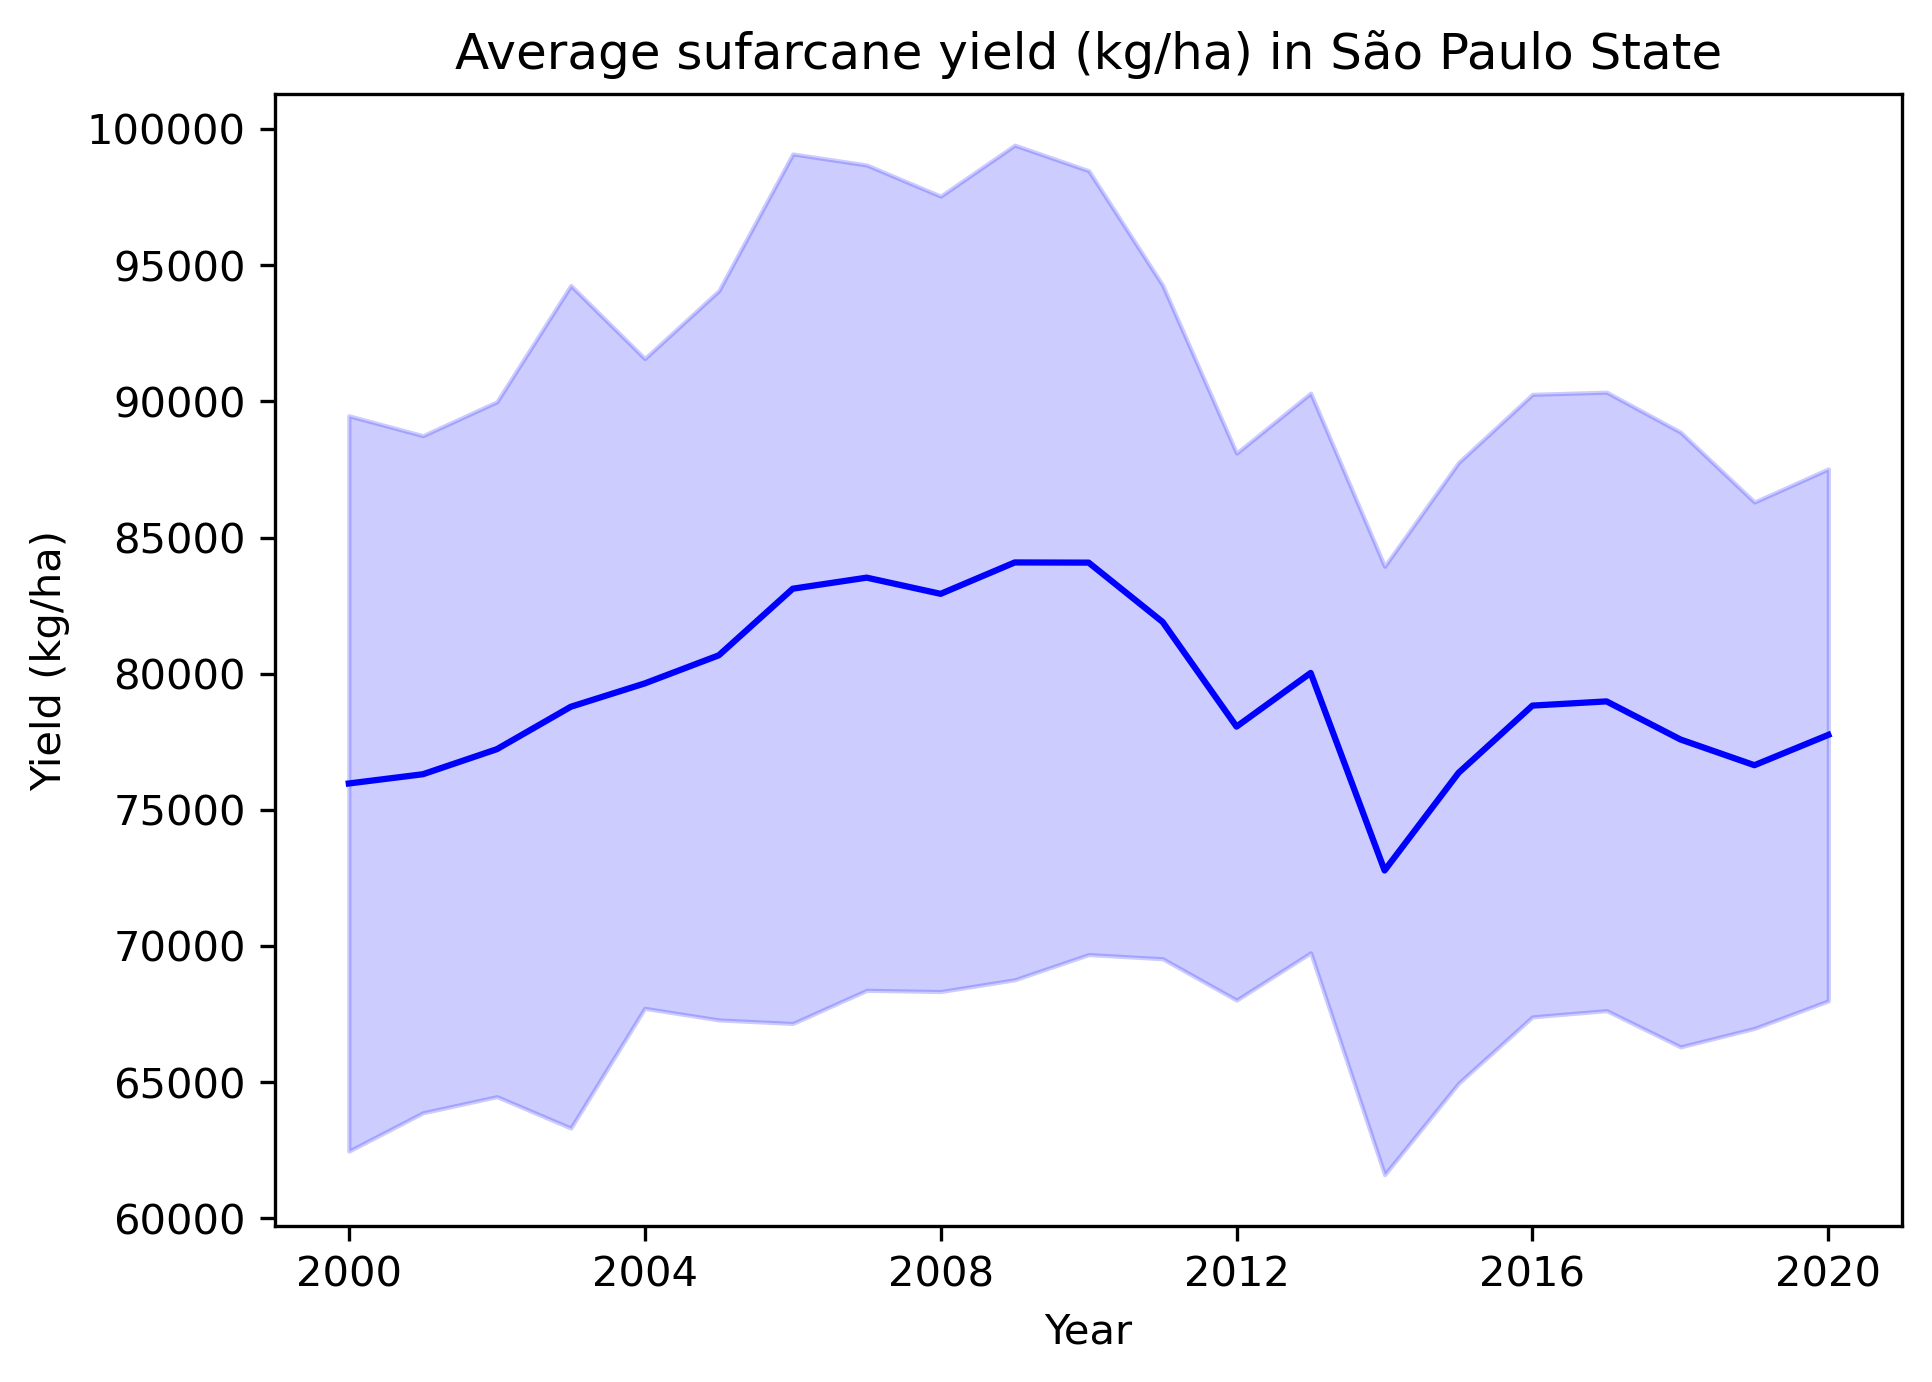

In [56]:
## Plot the mean and standard deviation by year
mean_plus_st = mean_st_merged['mean_yield'] +  mean_st_merged['st_yield']
mean_minus_st = mean_st_merged['mean_yield'] -  mean_st_merged['st_yield']

plt.figure(figsize=(7, 5), dpi=300)
plt.plot(mean_st_merged['YEAR'], mean_st_merged['mean_yield'], color = 'blue')
plt.fill_between(mean_st_merged['YEAR'], mean_plus_st, mean_minus_st, alpha = 0.2, color = 'blue')
plt.title("Average sufarcane yield (kg/ha) in São Paulo State")
plt.xlabel("Year")
plt.ylabel("Yield (kg/ha)")
plt.savefig('plot_avergae_st_yield.png', dpi=80)

plt.show()

With this graph we have a view of the average productivity and variability in the state of São Paulo (seeing the area in blue, which represents the standard deviation) over the 21 years of our study.

#### Part 2: Joining the yield productivity with the environmental variables

In [58]:
# Create a list with all the IDs of the counties
list_mun = dat_clean['CD_MUN'].tolist()
list_mun

In [60]:
# Load the environmental variables files and create a new dataset with only the IDs selected in the previous cell
aet = pd.read_csv('tables/aet.csv', sep = ';')
aet_new = aet[aet['CD_MUN'].isin(list_mun)].reset_index(drop = True)
ndvi = pd.read_csv('tables/ndvi.csv', sep = ';')
ndvi_new = ndvi[ndvi['CD_MUN'].isin(list_mun)].reset_index(drop = True)
npp = pd.read_csv('tables/npp.csv', sep = ';')
npp_new = npp[npp['CD_MUN'].isin(list_mun)].reset_index(drop = True)
soil = pd.read_csv('tables/soil.csv', sep = ';')
soil_new = soil[soil['CD_MUN'].isin(list_mun)].reset_index(drop = True)
pr = pd.read_csv('tables/pr.csv', sep = ';')
pr_new = pr[pr['CD_MUN'].isin(list_mun)].reset_index(drop = True)
lst = pd.read_csv('tables/LST.csv', sep = ';')
lst_new = lst[lst['CD_MUN'].isin(list_mun)].reset_index(drop = True)
tmmx = pd.read_csv('tables/tmmx.csv', sep = ';')
tmmx_new = tmmx[tmmx['CD_MUN'].isin(list_mun)].reset_index(drop = True)
tmin = pd.read_csv('tables/tmin.csv', sep = ';')
tmin_new = tmin[tmin['CD_MUN'].isin(list_mun)].reset_index(drop = True)

In [62]:
# Reshape the dataset, but first delete the 'mean' column
dat_clean.drop(['mean'], axis = 1, inplace = True)
dat_clean_yield = pd.melt(dat_clean, id_vars =['CD_MUN', 'County'])
dat_clean_yield['YEAR'] = dat_clean_yield['variable']
dat_clean_yield.drop(['variable'], axis = 1, inplace = True)

dat_clean_aet = pd.melt(aet_new, id_vars =['CD_MUN']).reset_index()
dat_clean_aet.rename(columns = {'value': 'AET'}, inplace = True)

dat_clean_ndvi = pd.melt(ndvi_new, id_vars =['CD_MUN']).reset_index()
dat_clean_ndvi.rename(columns = {'value': 'NDVI'}, inplace = True)

dat_clean_npp = pd.melt(npp_new, id_vars =['CD_MUN']).reset_index()
dat_clean_npp.rename(columns = {'value': 'NPP'}, inplace = True)

dat_clean_soil = pd.melt(soil_new, id_vars =['CD_MUN']).reset_index()
dat_clean_soil.rename(columns = {'value': 'SOIL'}, inplace = True)

dat_clean_pr = pd.melt(pr_new, id_vars =['CD_MUN']).reset_index()
dat_clean_pr.rename(columns = {'value': 'PR'}, inplace = True)

dat_clean_tmmx = pd.melt(tmmx_new, id_vars =['CD_MUN']).reset_index()
dat_clean_tmmx.rename(columns = {'value': 'TMMX'}, inplace = True)

dat_clean_tmin = pd.melt(tmin_new, id_vars =['CD_MUN']).reset_index()
dat_clean_tmin.rename(columns = {'value': 'TMIN'}, inplace = True)

In [63]:
# Merge all databases
dat_join = dat_clean_yield.join([dat_clean_aet['AET'], dat_clean_ndvi['NDVI'], dat_clean_npp['NPP'], dat_clean_soil['SOIL'],
                   dat_clean_tmin['TMIN'], dat_clean_tmmx['TMMX'], dat_clean_pr['PR']])

dat_join.head()

,CD_MUN,County,value,YEAR,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR
0,3500105.0,Adamantina (SP),50000.0,2000,704,5174,4047,166,163,288,91
1,3500204.0,Adolfo (SP),NaN,2000,716,4080,5245,255,162,290,94
2,3500303.0,Aguaí (SP),80000.0,2000,675,5614,8672,399,151,272,109
3,3500550.0,Águas de Santa Bárbara (SP),NaN,2000,776,5388,8146,246,142,270,95
4,3500709.0,Agudos (SP),70000.0,2000,746,5969,9080,248,146,274,94


In [64]:
# Convert 'CD_MUN' to integer
dat_join['CD_MUN'] = dat_join['CD_MUN'].astype(int)
dat_join.head()

,CD_MUN,County,value,YEAR,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR
0,3500105,Adamantina (SP),50000.0,2000,704,5174,4047,166,163,288,91
1,3500204,Adolfo (SP),NaN,2000,716,4080,5245,255,162,290,94
2,3500303,Aguaí (SP),80000.0,2000,675,5614,8672,399,151,272,109
3,3500550,Águas de Santa Bárbara (SP),NaN,2000,776,5388,8146,246,142,270,95
4,3500709,Agudos (SP),70000.0,2000,746,5969,9080,248,146,274,94


#### Load and plot rasters

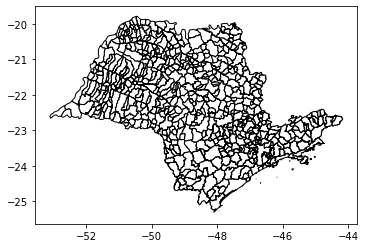

In [65]:
# Load the shapefile of SP state and plot
sp = gp.read_file('SP_Municipios_2021.shp')
sp.plot(fc = 'white', ec = 'black')
plt.show()

In [6]:
# Load and open rasters
with rasterio.open("raster/NDVI_2000-2021.tif") as NDVI_stack:
    NDVI_stack_data = NDVI_stack.read(masked=True)
    NDVI_stack_meta = NDVI_stack.profile
    
with rasterio.open("raster/LST_2000-2021.tif") as LST_stack:
    LST_stack_data = LST_stack.read()
    LST_stack_meta = LST_stack.profile
    
with rasterio.open("raster/tmin_bands.tif") as tmin_stack:
    tmin_stack_data = tmin_stack.read()
    tmin_stack_meta = tmin_stack.profile
    
with rasterio.open("raster/tmmx_bands.tif") as tmmx_stack:
    tmmx_stack_data = tmmx_stack.read()
    tmmx_stack_meta = tmmx_stack.profile
    
with rasterio.open("raster/soil_bands.tif") as soil_stack:
    soil_stack_data = soil_stack.read()
    soil_stack_meta = soil_stack.profile
    
with rasterio.open("raster/pr_bands.tif") as pr_stack:
    pr_stack_data = pr_stack.read()
    pr_stack_meta = pr_stack.profile
    
with rasterio.open("raster/aet_bands.tif") as aet_stack:
    aet_stack_data = aet_stack.read()
    aet_stack_meta = aet_stack.profile

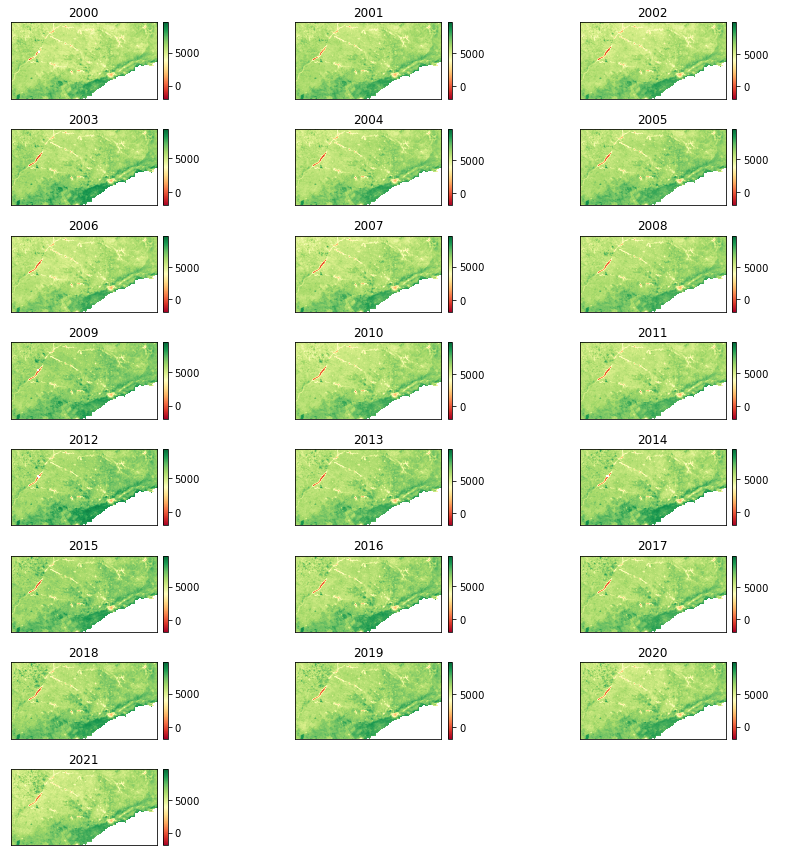

In [7]:
# Plot rasters - NDVI
band_titles=list(range(2000, 2022))

ep.plot_bands(NDVI_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
# Plot rasters - LST
ep.plot_bands(LST_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
# Plot rasters - T min
ep.plot_bands(tmin_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
# Plot rasters - T max
ep.plot_bands(tmmx_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()   

In [ ]:
# Plot rasters - Soil moisture
ep.plot_bands(soil_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
# Plot rasters - Evapotranspiration
ep.plot_bands(aet_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()

In [ ]:
# Plot rasters - Precipitation
ep.plot_bands(pr_stack_data,
              cmap='RdYlGn',
              scale=False,
              title=band_titles)

plt.show()